# TODO
* Match the PSD's
* read all 3 channels (x2)
* Use radius not diameter

# Imports

In [2]:
from config import BASE_PATH, TRACKS_PER_FILE, NUM_FILES
from config import Config
from series_processing import process_series
from file_io import check_and_load_or_process
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
    

# Load the transfer functions

Text(0.5, 1.0, 'Transfer Funtion')

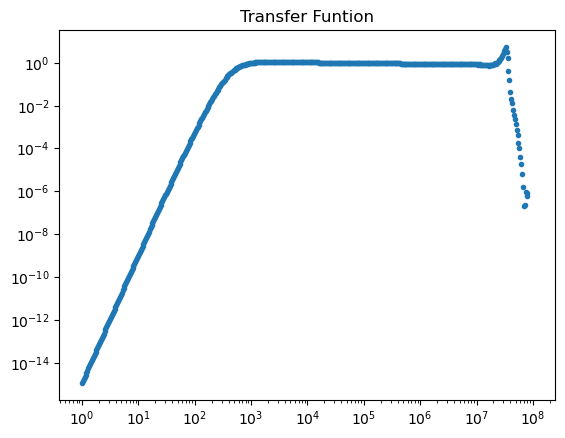

In [3]:
def transfer(freq, response):
    df = pd.read_csv(r"C:\Users\mcthu\Downloads\2 micron data\no_filter_response.txt")
    freqs = np.array(df[df.keys()[0]])
    r = np.array(df[df.keys()[1]])
    interpolation = scipy.interpolate.interp1d(freqs, r, fill_value = "extrapolate")
    
    def low_freq_fit(x):
        A, B =   -306.24611144, 184968.79274103
        C = 1 / (2*np.pi*10**-6*1000)
        Sallen_key = x**2 / (x**2 + A*x + B)
        RC_high_pass = x / (x +C )
        return (Sallen_key*RC_high_pass)**2
    
    return np.where(freq < 10**5, response / low_freq_fit(freq), response / interpolation(freq))

# Check out the tranfer function

freq = np.logspace(0, 8, 500)  # Frequencies from 10 Hz to 1 MHz
flat_psd = np.ones_like(freq)  # Flat PSD
psd_combined_f = transfer(freq, flat_psd)

plt.plot(freq, 1/psd_combined_f, ".")
plt.xscale("log")
plt.yscale("log")
plt.title("Transfer Funtion")


# Load the data

Processing data for 
Reading  C:\Users\GaGe\Desktop\Brownian_Data_2024\October_Gage_Data\20241122\2_um_long_4 0
data_col  Y
Reading  C:\Users\GaGe\Desktop\Brownian_Data_2024\October_Gage_Data\20241122\2_um_long_4 1
data_col  Y
Reading  C:\Users\GaGe\Desktop\Brownian_Data_2024\October_Gage_Data\20241122\2_um_long_4 2
data_col  Y
Reading  C:\Users\GaGe\Desktop\Brownian_Data_2024\October_Gage_Data\20241122\2_um_long_4 3
data_col  Y
Reading  C:\Users\GaGe\Desktop\Brownian_Data_2024\October_Gage_Data\20241122\2_um_long_4 4
data_col  Y
Reading  C:\Users\GaGe\Desktop\Brownian_Data_2024\October_Gage_Data\20241122\2_um_long_4 5
data_col  Y
Processing data for 
Reading  C:\Users\GaGe\Desktop\Brownian_Data_2024\October_Gage_Data\20241122\2_um_short_4 0
data_col  X
Reading  C:\Users\GaGe\Desktop\Brownian_Data_2024\October_Gage_Data\20241122\2_um_short_4 1
data_col  X
Reading  C:\Users\GaGe\Desktop\Brownian_Data_2024\October_Gage_Data\20241122\2_um_short_4 2
data_col  X
Reading  C:\Users\GaGe\Deskt

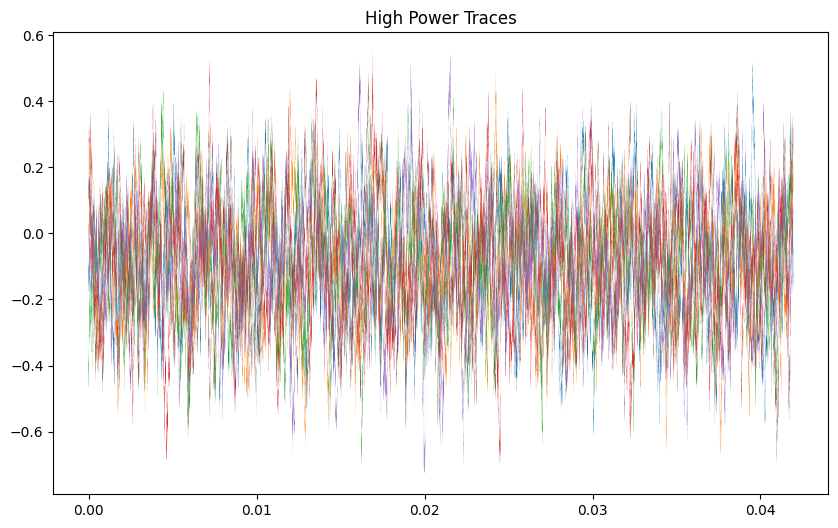

MASS TOTAL IS 1.767145867644259e-13


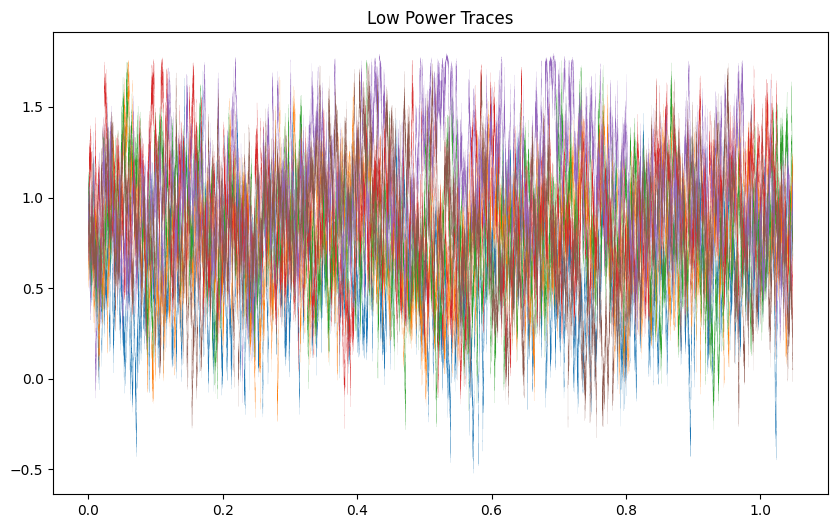

In [23]:
LP_filename = r"C:\Users\GaGe\Desktop\Brownian_Data_2024\October_Gage_Data\20241122\2_um_long_4"
lp_offset = 21
HP_filename = r"C:\Users\GaGe\Desktop\Brownian_Data_2024\October_Gage_Data\20241122\2_um_short_4"
hp_offset = 3

traces_LP = check_and_load_or_process("", lp_offset, LP_filename, "Y", NUM_FILES)

traces_HP = check_and_load_or_process("", hp_offset, HP_filename, "X", NUM_FILES)


time_hp = np.arange(0, len(traces_HP[0]['series']))
conf_hp = Config(**traces_HP[0]['args'])
time_hp = time_hp * (1/conf_hp.sampling_rate)

plt.figure(figsize=(10, 6))
for trace in traces_HP:
    plt.plot(time_hp, trace['series'], linewidth = .05)

plt.title("High Power Traces")
plt.show()

time_lp = np.arange(0, len(traces_LP[0]['series']))
conf_lp = Config(**traces_LP[0]['args'])
time_lp = time_lp * (1/conf_lp.sampling_rate)

plt.figure(figsize=(10, 6))
for trace in traces_LP:
    plt.plot(time_lp, trace['series'], linewidth = .05)

plt.title("Low Power Traces")
plt.show()


# Process the data


In [24]:
from allantools import *
results_hp = []
results_lp = []

for trace in traces_LP:
    result = process_series(trace['series'], conf_lp, bin=10)
    # print("sampling rate ", conf_lp.sampling_rate)
    # allan_dev = oadev(data=trace['series'], rate=conf_lp.sampling_rate)
    # plt.plot(allan_dev[0], allan_dev[1])
    # plt.xscale('log')
    # plt.yscale('log')
    results_lp.append(result)
    
for trace in traces_HP:
    result = process_series(trace['series'], conf_hp, bin=10)
    results_hp.append(result)

# Analyze the PSDs

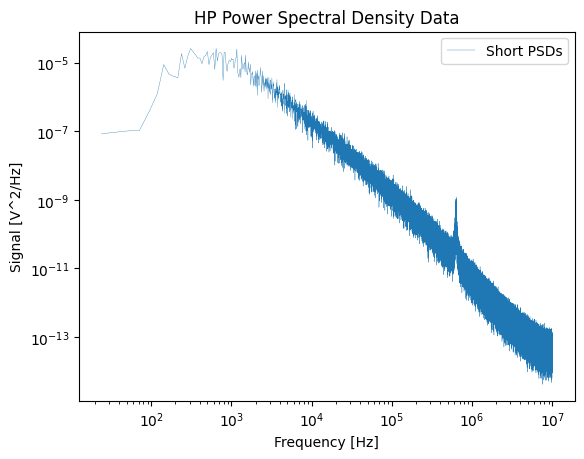

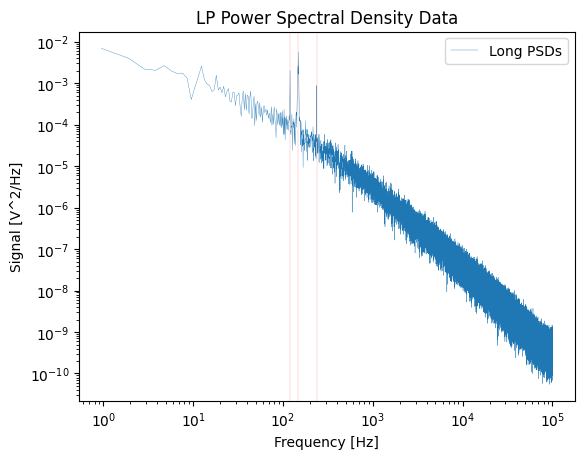

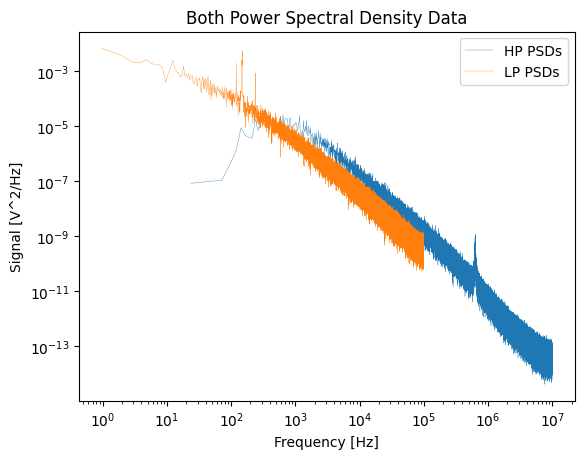

In [25]:
# Average the HP PSDs
hp_PSDs = np.array([item["psd"][1:-1] for item in results_hp])
hp_avg_psd = np.mean(hp_PSDs, axis=0)

lp_PSDs = np.array([item["psd"][1:-1] for item in results_lp])
lp_avg_psd = np.mean(lp_PSDs, axis=0)

freq_lp = results_lp[0]["frequency"][1:-1]
freq_hp = results_hp[0]["frequency"][1:-1]

plt.plot(freq_hp, hp_avg_psd, label="Short PSDs", linewidth=.25)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.title("HP Power Spectral Density Data")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Signal [V^2/Hz]")
plt.show()

plt.plot(freq_lp, lp_avg_psd, label="Long PSDs", linewidth=.25)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.title("LP Power Spectral Density Data")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Signal [V^2/Hz]")
plt.axvline(1.2e2, linewidth=.1, color='r')
plt.axvline(1.47e2, linewidth=.1, color='r')
plt.axvline(2.39e2, linewidth=.1, color='r')
plt.show()

plt.plot(freq_hp, hp_avg_psd, label="HP PSDs", linewidth=.25)
plt.plot(freq_lp, lp_avg_psd, label="LP PSDs", linewidth=.25)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.title("Both Power Spectral Density Data")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Signal [V^2/Hz]")
plt.show()

# Divide High Power by the transfer functions

Text(0, 0.5, 'Signal [V^2/Hz]')

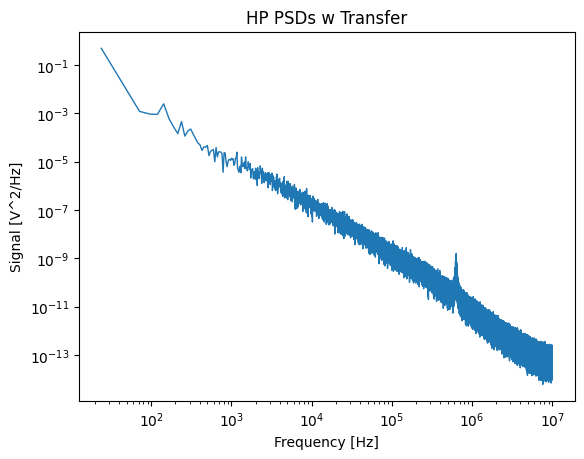

In [26]:
hp_avg_psd = transfer(freq_hp, hp_avg_psd)

plt.plot(freq_hp, hp_avg_psd,linewidth=1)
plt.xscale("log")
plt.yscale("log")
plt.title("HP PSDs w Transfer")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Signal [V^2/Hz]")

# Analyze the bright noise

Processing data for 
Reading  C:\Users\GaGe\Desktop\Brownian_Data_2024\October_Gage_Data\20241122\2_um_long_4_bright 0
data_col  Y
Reading  C:\Users\GaGe\Desktop\Brownian_Data_2024\October_Gage_Data\20241122\2_um_long_4_bright 1
data_col  Y
Reading  C:\Users\GaGe\Desktop\Brownian_Data_2024\October_Gage_Data\20241122\2_um_long_4_bright 2
data_col  Y
Reading  C:\Users\GaGe\Desktop\Brownian_Data_2024\October_Gage_Data\20241122\2_um_long_4_bright 3
data_col  Y
Reading  C:\Users\GaGe\Desktop\Brownian_Data_2024\October_Gage_Data\20241122\2_um_long_4_bright 4
data_col  Y
Reading  C:\Users\GaGe\Desktop\Brownian_Data_2024\October_Gage_Data\20241122\2_um_long_4_bright 5
data_col  Y
Processing data for 
Reading  C:\Users\GaGe\Desktop\Brownian_Data_2024\October_Gage_Data\20241122\2_um_short_4_bright 0
data_col  X
Reading  C:\Users\GaGe\Desktop\Brownian_Data_2024\October_Gage_Data\20241122\2_um_short_4_bright 1
data_col  X
Reading  C:\Users\GaGe\Desktop\Brownian_Data_2024\October_Gage_Data\20241122

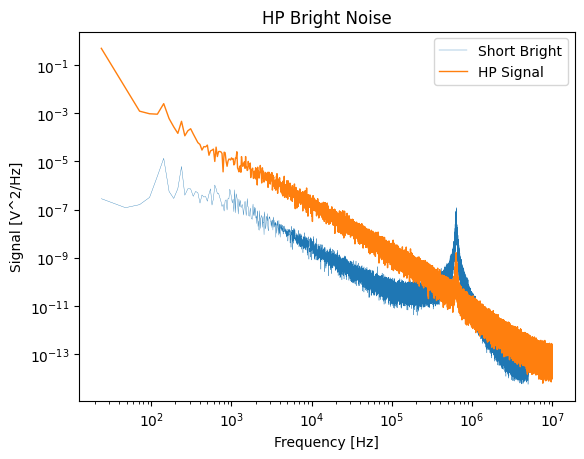

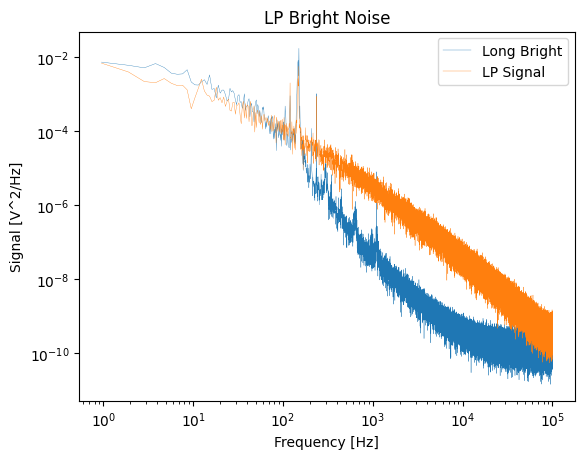

In [27]:
LPB_filename = r"C:\Users\GaGe\Desktop\Brownian_Data_2024\October_Gage_Data\20241122\2_um_long_4_bright"
lpb_offset = 71
HPB_filename = r"C:\Users\GaGe\Desktop\Brownian_Data_2024\October_Gage_Data\20241122\2_um_short_4_bright"
hpb_offset = 87

traces_LPB = check_and_load_or_process("", lpb_offset, LPB_filename, "Y", NUM_FILES)

traces_HPB = check_and_load_or_process("", hpb_offset, HPB_filename, "X", NUM_FILES)

time_hpb = np.arange(0, len(traces_HPB[0]['series']))
conf_hpb = Config(**traces_HPB[0]['args'])
time_hpb = time_hpb * (1/conf_hp.sampling_rate)

time_lpb = np.arange(0, len(traces_LPB[0]['series']))
conf_lpb = Config(**traces_LPB[0]['args'])
time_lpb = time_lpb * (1/conf_lpb.sampling_rate)

results_hpb = []
results_lpb = []

for trace in traces_LPB:
    result = process_series(trace['series'], conf_lpb, bin=10)
    results_lpb.append(result)

for trace in traces_HPB:
    result = process_series(trace['series'], conf_hpb, bin=20)
    results_hpb.append(result)

# Average the HP PSDs
hpb_PSDs = np.array([item["psd"][1:-1] for item in results_hpb])
hpb_avg_psd = np.mean(hpb_PSDs, axis=0)

lpb_PSDs = np.array([item["psd"][1:-1] for item in results_lpb])
lpb_avg_psd = np.mean(lpb_PSDs, axis=0)

freq_lpb = results_lpb[0]["frequency"][1:-1]
freq_hpb = results_hpb[0]["frequency"][1:-1]

plt.plot(freq_hpb, hpb_avg_psd, label="Short Bright", linewidth=.25)
plt.plot(freq_hp, hp_avg_psd,label="HP Signal", linewidth=1)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.title("HP Bright Noise")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Signal [V^2/Hz]")
plt.show()

plt.plot(freq_lpb, lpb_avg_psd, label="Long Bright", linewidth=.25)
plt.plot(freq_lp, lp_avg_psd, label="LP Signal", linewidth=.25)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.title("LP Bright Noise")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Signal [V^2/Hz]")
plt.show()

# Subtract the bright noise

In [28]:
lp_avg_psd = (lp_avg_psd -lpb_avg_psd)
hp_avg_psd = (hp_avg_psd - hpb_avg_psd)

plt.plot(freq_hpb, hpb_avg_psd, label="Short Bright", linewidth=.1)
plt.plot(freq_hp, hp_avg_psd,label="HP Signal", linewidth=.1)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.title("HP Subtracted Signal")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Signal [V^2/Hz]")
plt.show()

plt.plot(freq_lpb, lpb_avg_psd, label="Long Bright", linewidth=.1)
plt.plot(freq_lp, lp_avg_psd, label="LP Signal", linewidth=.1)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.title("LP Subtracted Signal")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Signal [V^2/Hz]")
plt.show()


ValueError: operands could not be broadcast together with shapes (419429,) (209714,) 

# Clean the low power PSD

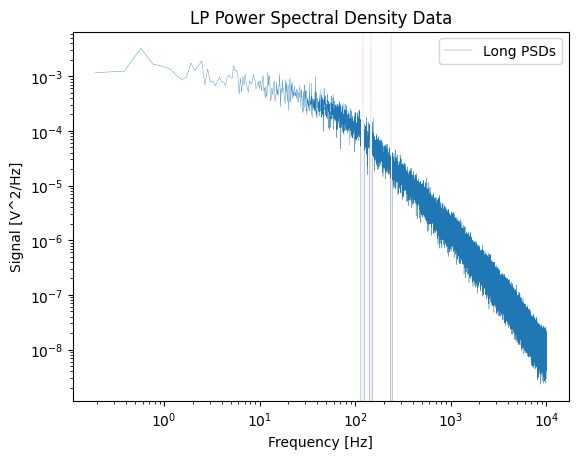

In [39]:
def remove_frequency_artifact(freq, psd, artifact_center, artifact_bandwidth):
    # Create a mask for frequencies to remove
    mask = (np.abs(freq - artifact_center) <= artifact_bandwidth / 2)

    # Remove the artifact by zeroing out the PSD values in the specified range
    v_psd_cleaned = np.copy(psd)
    v_psd_cleaned[mask] = 0

    return v_psd_cleaned

#
# artifact_center_width = [(1.2e2, 10), (1.47e2, 10), (2.39e2, 10)]
#
# for center, width in artifact_center_width:
#     lp_avg_psd = remove_frequency_artifact(freq_lp, lp_avg_psd, center, width)
#
# plt.plot(freq_lp, lp_avg_psd, label="Long PSDs", linewidth=.25)
# plt.xscale("log")
# plt.yscale("log")
# plt.legend()
# plt.title("LP Power Spectral Density Data")
# plt.xlabel("Frequency [Hz]")
# plt.ylabel("Signal [V^2/Hz]")
# plt.axvline(1.2e2, linewidth=.1, color='r')
# plt.axvline(1.47e2, linewidth=.1, color='r')
# plt.axvline(2.39e2, linewidth=.1, color='r')
# plt.show()

# Combine the LP and HP PSDs

Text(0, 0.5, 'Signal [V^2/Hz]')

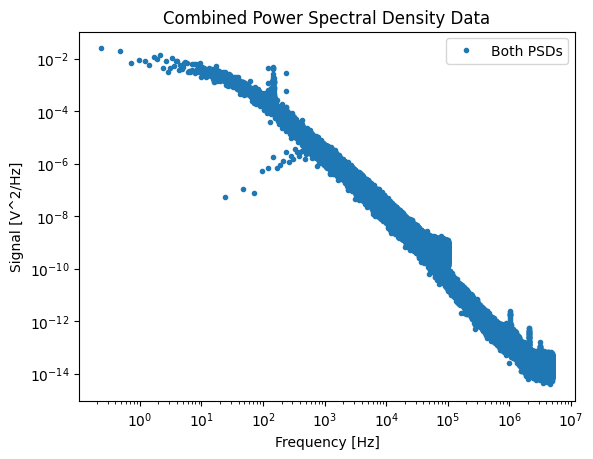

In [12]:

#Multiply the lp by some factor
lp_avg_psd *=8

freq_combined = np.concatenate((freq_lp, freq_hp))
psd_combined = np.concatenate((lp_avg_psd, hp_avg_psd))

# Sort the combined arrays by frequency
sorted_indices = np.argsort(freq_combined)
freq_combined = freq_combined[sorted_indices]
psd_combined = psd_combined[sorted_indices]

plt.plot(freq_combined, psd_combined, ".", label="Both PSDs", linewidth=.25)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.title("Combined Power Spectral Density Data")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Signal [V^2/Hz]")

# Log bin the PSD

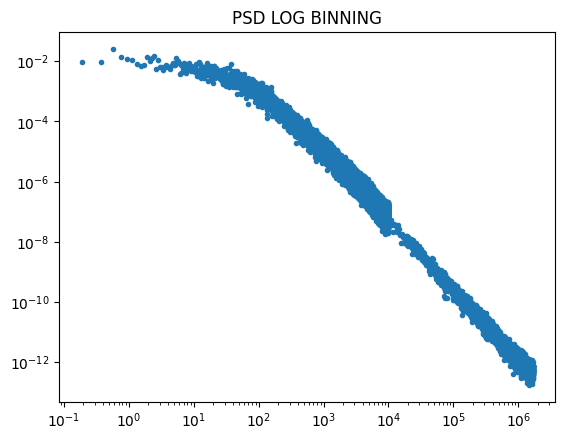

In [41]:
from fitting import log_bin_array, PSD_fitting, PSD_fitting_func

# freqs, PSD = log_bin_array(freq_combined, psd_combined, 5, 2e6, 200)
freqs, PSD = freq_combined, psd_combined

plt.plot(freqs, PSD, ".")
plt.title("PSD LOG BINNING")
plt.xscale("log")
plt.yscale("log")
plt.show()

# Fit the combined PSD

In [13]:
from fitting import log_bin_array, PSD_fitting, PSD_fitting_func

a_guess = 2.5e-6
v_guess = 1e8
m_guess = 1e-13
k_guess = 5e-5

# bounds = [(a_guess, a_guess), (m_guess, m_guess), (k_guess, k_guess), (v_guess, v_guess)]

optimal_parameters = PSD_fitting(freqs, PSD, a_guess, m_guess, k_guess, v_guess)
optimal_parameters.x[0] = optimal_parameters.x[0]*1e-14
PSD_fit = PSD_fitting_func(freqs * 2 * np.pi, optimal_parameters.x[0], optimal_parameters.x[1], a_guess, optimal_parameters.x[2])

print("Parameters = ", optimal_parameters.x)
plt.text(0.1, 0.1, f"Optimal Values:\nMass = {optimal_parameters.x[0]}\nK = {optimal_parameters.x[1]}\nA = {a_guess}\nV = {optimal_parameters.x[2]}",
         fontsize=8, ha='left', va='bottom', transform=plt.gca().transAxes)
plt.text(0.1, 0.3, f"True Values:\nMass = {conf_hp.mass_total}\nK = {.1}\nA = {conf_hp.a}\nV = {1}",
         fontsize=8, ha='left', va='bottom', transform=plt.gca().transAxes)

plt.plot(freqs[1:], PSD[1:], ".")

# plt.axhline(2*const.k_b*conf.temp*config.gamma/k_guess**2)

plt.plot(freqs[1:], PSD_fit[1:], label="fit")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.show()


NameError: name 'freqs' is not defined

# Analyze the VPSDs

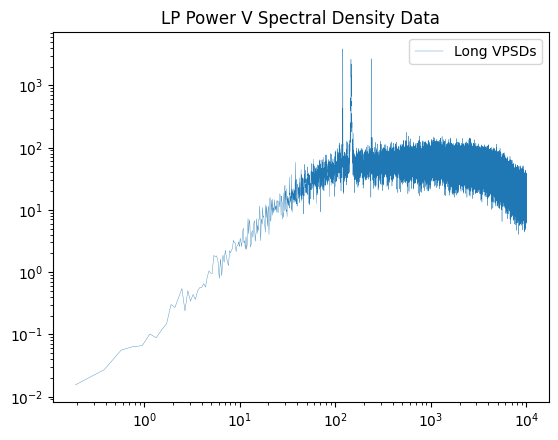

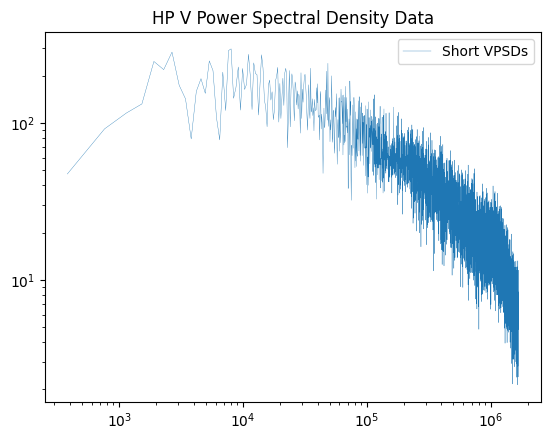

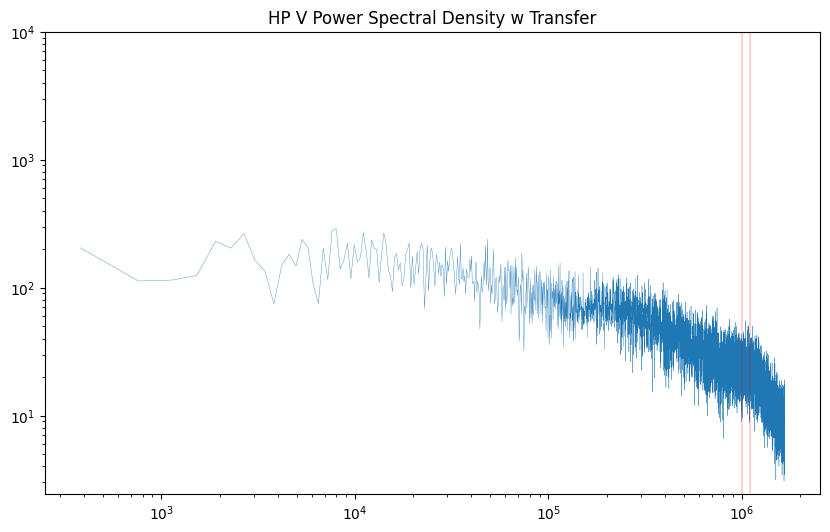

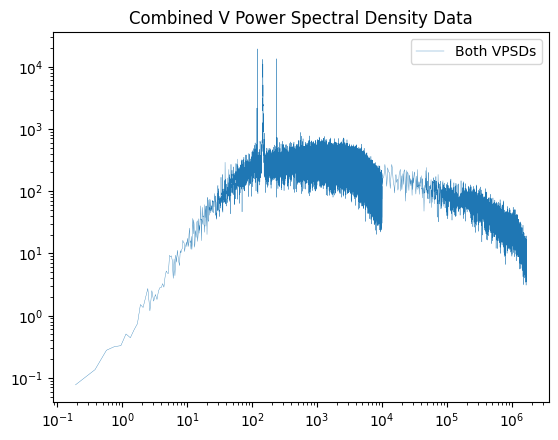

In [43]:
hp_VPSDs = np.array([item["v_psd"][1:-1] for item in results_hp])
hp_avg_vpsd = np.mean(hp_VPSDs, axis=0)

lp_VPSDs = np.array([item["v_psd"][1:-1] for item in results_lp])
lp_avg_vpsd = np.mean(lp_VPSDs, axis=0)

vfreq_lp = results_lp[0]["v_freq"][1:-1]
vfreq_hp = results_hp[0]["v_freq"][1:-1]

plt.plot(vfreq_lp, lp_avg_vpsd, label="Long VPSDs", linewidth=.25)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.title("LP Power V Spectral Density Data")
plt.show()

plt.plot(vfreq_hp, hp_avg_vpsd, label="Short VPSDs", linewidth=.25)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.title("HP V Power Spectral Density Data")
plt.show()

# Divide the HP VPSD by the transfer function
hp_avg_vpsd = transfer(vfreq_hp, hp_avg_vpsd)

plt.figure(figsize=(10, 6))
plt.plot(vfreq_hp, hp_avg_vpsd, linewidth=.25)
plt.xscale("log")
plt.yscale("log")
plt.ylim(top=10**4)
plt.axvline(1e6, linewidth=.25, color='r')
plt.axvline(1.1e6, linewidth=.25, color='r')
plt.title("HP V Power Spectral Density w Transfer")
plt.show()

# # cut the high power high f
# mask = vfreq_hp <= 2e6
# vfreq_hp = vfreq_hp[mask]
# hp_avg_vpsd = hp_avg_vpsd[mask]

#Multiply the lp by some factor
lp_avg_vpsd *=5

# Combine the psds together

vfreq_combined = np.concatenate((vfreq_lp, vfreq_hp))
vpsd_combined = np.concatenate((lp_avg_vpsd, hp_avg_vpsd))

# Sort the combined arrays by frequency
v_sorted_indices = np.argsort(vfreq_combined)
vfreq_combined = vfreq_combined[v_sorted_indices]
vpsd_combined = vpsd_combined[v_sorted_indices]

plt.plot(vfreq_combined, vpsd_combined, label="Both VPSDs", linewidth=.25)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.title("Combined V Power Spectral Density Data")
plt.show()


# Remove externalities

In [44]:
#
# artifact_center = 1e6  # 5 MHz
# artifact_bandwidth = 1e5  # 100 kHz
# 
# # Remove artifact
# hp_avg_vpsd = remove_frequency_artifact(vfreq_hp, hp_avg_vpsd, artifact_center, artifact_bandwidth)
# 
# 
# plt.plot(vfreq_hp, hp_avg_vpsd, label="Short VPSDs", linewidth=.25)
# plt.xscale("log")
# plt.yscale("log")
# plt.legend()
# plt.title("HP V Power Spectral Density Data")
# plt.show()



# Analyze the VACFs

In [14]:
from fitting import *
v_acf = np.fft.ifft(hp_avg_vpsd).real  # Real part gives the ACF (ignore imaginary part from numerical error)

# Compute lag times
n_points = len(hp_avg_vpsd)
print(conf_hp.sampling_rate)

lag_time_resolution = 1 / (2 * np.max(vfreq_hp))
v_lags = np.arange(0, n_points) * (lag_time_resolution)

# Plot VACF with log x-axis
plt.figure(figsize=(10, 6))
v_acf=v_acf/v_acf[1]
plt.plot(v_lags, v_acf, ".", label="HP VACF")
plt.xscale("log")
plt.xlabel("Lag Time (s)")
plt.ylabel("VACF")

vacf_true = VACF_fitting_func(v_lags, conf_hp.mass, 200e-6, conf_hp.a, V=1.0)
vacf_true=vacf_true/vacf_true[0]
plt.plot(v_lags, vacf_true,linewidth=1, label="True VACF")
plt.xscale("log")
plt.xlabel("Lag Time (s)")
plt.ylabel("VACF")
plt.xlim(right = 10**-4)
plt.ylim(top=1.0)
plt.title("Velocity Auto-Correlation Function (VACF)")
plt.legend()


NameError: name 'hp_avg_vpsd' is not defined